In [1]:
import pandas as pd
import numpy as np
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# for training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# for optimize
from skopt import gp_minimize, Optimizer
from skopt.space import Space, Integer, Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# custom packages
from bayes_opt import custom_minimize, resume_optimize
from agent import AgentBase

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from model import model

%load_ext autoreload
%autoreload 2


In [2]:
# meta config
random_seed = 2022

In [3]:
# space = Space((Integer(1, 12), Real(0.001, 10, prior="log-uniform", base=10)))
space = [[-15, 15], [-15, 15]]
x0 = [(14, 14)]
n_calls = 40
n_random_starts = 5

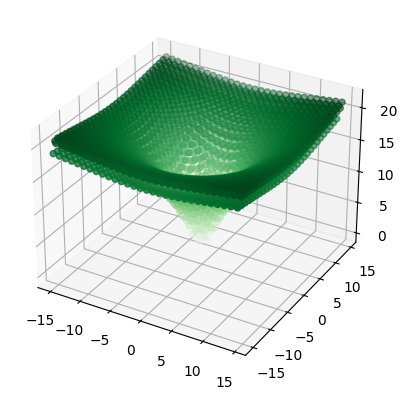

In [4]:
# visualize the graph
nx = np.arange(space[0][0], space[0][1], 0.5)
ny = np.arange(space[1][0], space[1][1], 0.5)
X, Y = np.meshgrid(nx, ny)
f = np.array([model((x, y)) for x, y in zip(X,Y)])

ax = plt.axes(projection='3d')

ax.scatter3D(X, Y, f, c=f, cmap='Greens')
plt.savefig("./figs/objective_ackley.pdf", bbox_inches="tight", dpi=300, format="pdf")

In [5]:
res_default = gp_minimize(model,        # the function to minimize
                    space,      # the bounds on each dimension of x
                    initial_point_generator="grid",
                    x0=x0,
                    acq_func="EI",      # the acquisition function
                    n_calls=n_calls,         # the number of evaluations of f
                    n_random_starts=n_random_starts,  # the number of random initialization points
                    noise="gaussian",       # the noise level (optional)
                    n_jobs=-1,
                    random_state=random_seed
                )   # the random seed

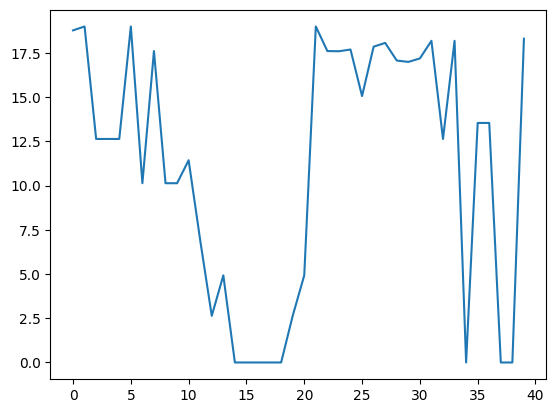

In [6]:
plt.plot(res_default.func_vals)

In [7]:
res_default

          fun: 0.0
            x: [0, 0]
    func_vals: [ 1.878e+01  1.900e+01 ...  0.000e+00  1.831e+01]
      x_iters: [(14, 14), [-15, -15], [-5, -5], [5, -5], [5, 5], [-15, 15], [5, 0], [-15, 1], [5, 0], [5, 0], [6, 0], [3, 0], [1, 0], [-2, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [0, -2], [15, -15], [-1, 15], [0, -15], [15, -3], [-7, 7], [15, 5], [-15, -7], [8, -11], [6, 12], [-7, -12], [-15, 8], [-1, 7], [-8, 15], [0, 0], [0, -8], [-8, 0], [0, 0], [0, 0], [15, -9]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_state=40194941), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        n

In [8]:
agent_a = AgentBase(dim=0, random_seed=random_seed)
agent_b = AgentBase(dim=1, random_seed=random_seed)

In [9]:
res, optimizer = agent_a.initialize_model(
                            model,
                            space,
                            x0,
                            initial_point_generator="grid",
                            acq_func="EI",      # the acquisition function
                            n_random_starts=n_random_starts,         # the number of evaluations of f
                        )

In [10]:
# params
records = res.func_vals
rounds = 5
budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
res_resume_b = res
res_resume_a = res

for _ in range(rounds):
    # Agent A iterates
    agent_a.punish_count = 0
    other_dim = agent_b.dim
    other_val = res_resume_b.x[other_dim]

    res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
                                        model,
                                        budget_a,
                                        res_resume_b,
                                        optimizer,
                                        other_dim,
                                        other_val
                                        )
    # Agent B iterates
    agent_b.punish_count = 0
    other_dim = agent_a.dim
    other_val = res_resume_a.x[other_dim]

    res_resume_b_next, optimizer, xs_b, ys_b = agent_b.update(
                                        model,
                                        budget_b,
                                        res_resume_a,
                                        optimizer,
                                        other_dim,
                                        other_val
                                        )

    # check whether to punish
    r_star = min(min(ys_a), min(ys_b)) - min(records)
    r_f = min(ys_a) - min(records)


    # update params
    res_resume_a = res_resume_a_next
    res_resume_b = res_resume_b_next
    records = np.concatenate([records, ys_a, ys_b])

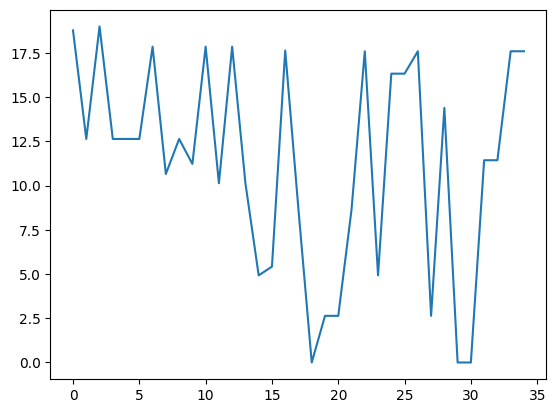

In [11]:
plt.plot(records)

Text(0, 0.5, 'Objective Value')

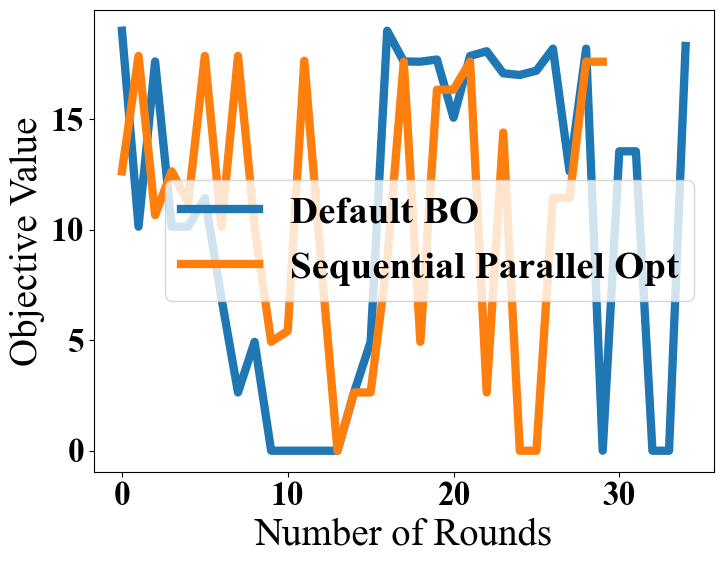

In [12]:
from plot_utils import set_up_plotting
set_up_plotting()

# compare the two approaches
plt.figure(figsize=(8, 6))
plt.plot(res_default.func_vals[n_random_starts:], label="Default BO")
plt.plot(records[n_random_starts:], label="Sequential Parallel Opt")
plt.legend(fontsize=28)
plt.xlabel("Number of Rounds", fontsize=28)
plt.ylabel("Objective Value", fontsize=28)

# plt.savefig("./figs/akley_perf.pdf", dpi=300, bbox_inches="tight", format="pdf")